# Phase 3: Baseline Models & Time-Series CV

This notebook implements baseline models and time-series cross-validation.

**Objectives:**
- Load featured data from Phase 2
- Implement expanding window time-series cross-validation
- Train naive baseline (last week's sales)
- Train simple LightGBM baseline
- Evaluate models using RMSPE metric
- Save baseline metrics for comparison

**CRITICAL:** All CV uses expanding windows with strict temporal ordering to prevent data leakage.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import lightgbm as lgb
import json
from datetime import datetime, timedelta

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration
CV_CONFIG = {
    'method': 'expanding',
    'n_folds': 5,
    'fold_length_days': 42,  # 6 weeks
    'min_train_days': 365    # 1 year minimum training data
}

# Ensure output directories
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)
Path('../outputs/metrics/baseline').mkdir(parents=True, exist_ok=True)

print("Setup complete!")
print(f"CV Configuration: {CV_CONFIG['n_folds']} folds, {CV_CONFIG['fold_length_days']} day validation periods")

Setup complete!
CV Configuration: 5 folds, 42 day validation periods


## 1. Load Featured Data

In [2]:
# Load featured data from Phase 2
df = pd.read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of stores: {df['Store'].nunique()}")
print(f"\nColumns: {len(df.columns)}")
print(f"Features: {len(df.columns) - 18}")  # Approx features (total - original cols)

Loaded data shape: (1017209, 49)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Number of stores: 1115

Columns: 49
Features: 31


## 2. Filter Data

Remove closed stores (Open=0) as they have Sales=0 and are ignored in RMSPE.

In [3]:
# Configuration is now in setup cell
print(f"Cross-Validation Configuration:")
print(f"  Method: {CV_CONFIG['method']}")
print(f"  Number of folds: {CV_CONFIG['n_folds']}")
print(f"  Fold length: {CV_CONFIG['fold_length_days']} days ({CV_CONFIG['fold_length_days']//7} weeks)")
print(f"  Minimum train days: {CV_CONFIG['min_train_days']} days ({CV_CONFIG['min_train_days']//365} year)")

Cross-Validation Configuration:
  Method: expanding
  Number of folds: 5
  Fold length: 42 days (6 weeks)
  Minimum train days: 365 days (1 year)


## 3. Filter Data & Helper Functions

Remove closed stores and define helper functions for CV and metrics.

In [4]:
# Filter to open stores only
initial_size = len(df)
df_open = df[df['Open'] == 1].copy()

print(f"Filtered {initial_size - len(df_open):,} closed store-days ({(initial_size - len(df_open))/initial_size*100:.2f}%)")
print(f"Remaining: {len(df_open):,} open store-days")

# Define RMSPE metric
def rmspe(y_true, y_pred, ignore_zero_sales=True):
    """
    Calculate Root Mean Square Percentage Error.
    
    Parameters:
    - y_true: Actual values
    - y_pred: Predicted values
    - ignore_zero_sales: If True, ignore observations where y_true == 0
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if ignore_zero_sales:
        mask = y_true != 0
    else:
        mask = np.ones_like(y_true, dtype=bool)
    
    if mask.sum() == 0:
        return np.nan
    
    return np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask])))

print("\n✓ Defined RMSPE metric function")

Filtered 172,817 closed store-days (16.99%)
Remaining: 844,392 open store-days

✓ Defined RMSPE metric function


## 4. Create Time-Series CV Folds

Use expanding window splits where each fold trains on all historical data.

In [5]:
# Create time-series CV folds with expanding window
def make_time_series_folds(df, n_folds, fold_length_days, min_train_days):
    """
    Create expanding window time-series cross-validation folds.
    
    Each fold:
    - Training set: All data from start up to validation start
    - Validation set: Fixed length period after training
    """
    print("="*60)
    print("Creating time-series cross-validation folds")
    print("="*60)
    print(f"Number of folds: {n_folds}")
    print(f"Validation fold length: {fold_length_days} days ({fold_length_days//7} weeks)")
    print(f"Minimum training days: {min_train_days} days")
    
    # Get unique dates sorted
    unique_dates = pd.Series(df['Date'].unique()).sort_values().reset_index(drop=True)
    
    print(f"Date range: {unique_dates.iloc[0]} to {unique_dates.iloc[-1]}")
    print(f"Total unique dates: {len(unique_dates)}")
    
    # Find first date that allows min_train_days
    min_train_end = unique_dates.iloc[0] + pd.Timedelta(days=min_train_days)
    first_val_start_idx = (unique_dates >= min_train_end).idxmax()
    
    print(f"\nFirst validation period starts at: {unique_dates.iloc[first_val_start_idx]}")
    
    folds = []
    
    for fold_num in range(n_folds):
        # Validation start date
        val_start_idx = first_val_start_idx + (fold_num * fold_length_days)
        if val_start_idx >= len(unique_dates):
            break
            
        val_start = unique_dates.iloc[val_start_idx]
        
        # Validation end date
        val_end_idx = min(val_start_idx + fold_length_days, len(unique_dates) - 1)
        val_end = unique_dates.iloc[val_end_idx]
        
        # Training end is day before validation starts
        train_end = val_start - pd.Timedelta(days=1)
        train_start = unique_dates.iloc[0]
        
        # Get indices
        train_mask = (df['Date'] >= train_start) & (df['Date'] <= train_end)
        val_mask = (df['Date'] >= val_start) & (df['Date'] <= val_end)
        
        train_idx = df[train_mask].index
        val_idx = df[val_mask].index
        
        fold_info = {
            'fold': fold_num + 1,
            'train_idx': train_idx,
            'val_idx': val_idx,
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end
        }
        
        folds.append(fold_info)
        
        print(f"\nFold {fold_num + 1}:")
        print(f"  Train: {train_start.date()} to {train_end.date()} ({len(train_idx):,} samples)")
        print(f"  Val:   {val_start.date()} to {val_end.date()} ({len(val_idx):,} samples)")
    
    print("="*60)
    print(f"Created {len(folds)} time-series CV folds")
    print("="*60)
    
    return folds

# Create CV folds
folds = make_time_series_folds(
    df_open,
    n_folds=CV_CONFIG['n_folds'],
    fold_length_days=CV_CONFIG['fold_length_days'],
    min_train_days=CV_CONFIG['min_train_days']
)

print(f"\n✓ Created {len(folds)} CV folds")

Creating time-series cross-validation folds
Number of folds: 5
Validation fold length: 42 days (6 weeks)
Minimum training days: 365 days
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Total unique dates: 942

First validation period starts at: 2014-01-01 00:00:00

Fold 1:
  Train: 2013-01-01 to 2013-12-31 (337,943 samples)
  Val:   2014-01-01 to 2014-02-12 (39,874 samples)

Fold 2:
  Train: 2013-01-01 to 2014-02-11 (376,704 samples)
  Val:   2014-02-12 to 2014-03-26 (41,274 samples)

Fold 3:
  Train: 2013-01-01 to 2014-03-25 (416,868 samples)
  Val:   2014-03-26 to 2014-05-07 (38,132 samples)

Fold 4:
  Train: 2013-01-01 to 2014-05-06 (453,886 samples)
  Val:   2014-05-07 to 2014-06-18 (39,221 samples)

Fold 5:
  Train: 2013-01-01 to 2014-06-17 (491,994 samples)
  Val:   2014-06-18 to 2014-07-30 (35,916 samples)
Created 5 time-series CV folds

✓ Created 5 CV folds


In [6]:
# Create fold summary DataFrame
fold_summary = pd.DataFrame([
    {
        'fold': f['fold'],
        'train_start': f['train_start'],
        'train_end': f['train_end'],
        'train_size': len(f['train_idx']),
        'val_start': f['val_start'],
        'val_end': f['val_end'],
        'val_size': len(f['val_idx']),
        'train_days': (f['train_end'] - f['train_start']).days,
        'val_days': (f['val_end'] - f['val_start']).days
    }
    for f in folds
])

print("\nFold Summary:")
display(fold_summary)


Fold Summary:


,fold,train_start,train_end,train_size,val_start,val_end,val_size,train_days,val_days
0,1,2013-01-01,2013-12-31,337943,2014-01-01,2014-02-12,39874,364,42
1,2,2013-01-01,2014-02-11,376704,2014-02-12,2014-03-26,41274,406,42
2,3,2013-01-01,2014-03-25,416868,2014-03-26,2014-05-07,38132,448,42
3,4,2013-01-01,2014-05-06,453886,2014-05-07,2014-06-18,39221,490,42
4,5,2013-01-01,2014-06-17,491994,2014-06-18,2014-07-30,35916,532,42


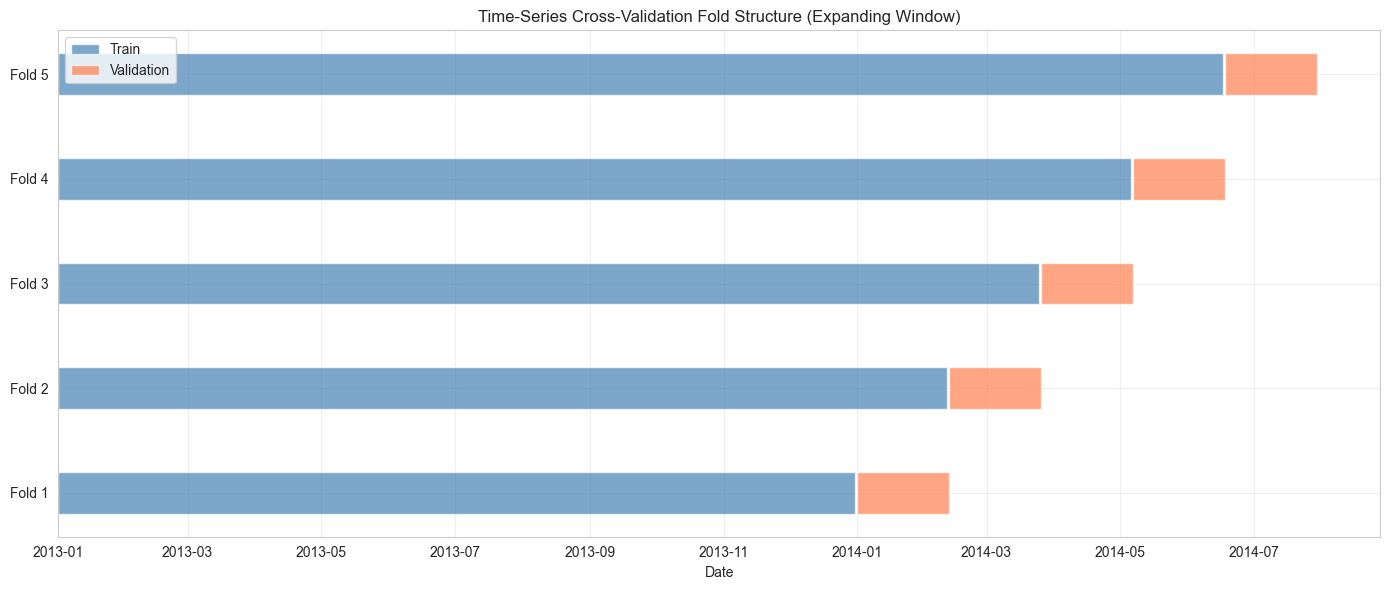

Saved: outputs/figures/10_cv_fold_structure.png


In [7]:
# Visualize fold structure
fig, ax = plt.subplots(figsize=(14, 6))

for idx, row in fold_summary.iterrows():
    # Training period
    ax.barh(idx, (row['train_end'] - row['train_start']).days, 
            left=row['train_start'], 
            height=0.4, 
            color='steelblue', 
            alpha=0.7,
            label='Train' if idx == 0 else '')
    
    # Validation period
    ax.barh(idx, (row['val_end'] - row['val_start']).days, 
            left=row['val_start'], 
            height=0.4, 
            color='coral', 
            alpha=0.7,
            label='Validation' if idx == 0 else '')

ax.set_yticks(range(len(fold_summary)))
ax.set_yticklabels([f"Fold {i+1}" for i in range(len(fold_summary))])
ax.set_xlabel('Date')
ax.set_title('Time-Series Cross-Validation Fold Structure (Expanding Window)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/10_cv_fold_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/figures/10_cv_fold_structure.png")

## 5. Naive Baseline: Last Week Model

Simple baseline that predicts current sales using last week's sales (7-day lag).

In [8]:
# Train naive baseline - use Sales_Lag_7 as prediction
print("="*60)
print("Training Naive Last-Week Model")
print("="*60)
print("Using Sales_Lag_7 as prediction\n")

naive_fold_scores = []

for fold in folds:
    # Get validation data
    val_data = df_open.loc[fold['val_idx']]
    
    # Use 7-day lag as prediction
    y_true = val_data['Sales'].values
    y_pred = val_data['Sales_Lag_7'].values
    
    # Remove missing predictions (can happen at start)
    mask = ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # Calculate RMSPE
    score = rmspe(y_true, y_pred)
    naive_fold_scores.append(score)
    
    print(f"Fold {fold['fold']}: RMSPE = {score:.6f}")

naive_mean = np.mean(naive_fold_scores)
naive_std = np.std(naive_fold_scores)

print(f"\nMean RMSPE: {naive_mean:.6f} ± {naive_std:.6f}")
print("="*60)

# Store results
naive_results = {
    'model_name': 'Naive_LastWeek',
    'fold_scores': naive_fold_scores,
    'mean_score': naive_mean,
    'std_score': naive_std
}

Training Naive Last-Week Model
Using Sales_Lag_7 as prediction

Fold 1: RMSPE = 0.522350
Fold 2: RMSPE = 0.426042
Fold 3: RMSPE = 0.481619
Fold 4: RMSPE = 0.448138
Fold 5: RMSPE = 0.448979

Mean RMSPE: 0.465426 ± 0.033535


In [9]:
# Print CV summary for naive model
print("="*60)
print(f"{naive_results['model_name']} - Cross-Validation Results")
print("="*60)
print("Metric: RMSPE\n")

print("Per-fold scores:")
for i, score in enumerate(naive_results['fold_scores'], 1):
    print(f"  Fold {i}: {score:.6f}")

print(f"\nMean RMSPE: {naive_results['mean_score']:.6f}")
print(f"Std  RMSPE: {naive_results['std_score']:.6f}")
print(f"CV Range: [{naive_results['mean_score'] - naive_results['std_score']:.6f}, {naive_results['mean_score'] + naive_results['std_score']:.6f}]")
print("="*60)

# Save results (convert numpy types to Python types for JSON serialization)
output_file = Path('../outputs/metrics/baseline/naive_lastweek_cv_results.json')
with open(output_file, 'w') as f:
    json.dump({
        'model_name': naive_results['model_name'],
        'fold_scores': [float(x) for x in naive_results['fold_scores']],
        'mean_score': float(naive_results['mean_score']),
        'std_score': float(naive_results['std_score']),
        'timestamp': datetime.now().isoformat()
    }, f, indent=2)

print(f"\n✓ Saved results to {output_file}")

Naive_LastWeek - Cross-Validation Results
Metric: RMSPE

Per-fold scores:
  Fold 1: 0.522350
  Fold 2: 0.426042
  Fold 3: 0.481619
  Fold 4: 0.448138
  Fold 5: 0.448979

Mean RMSPE: 0.465426
Std  RMSPE: 0.033535
CV Range: [0.431890, 0.498961]

✓ Saved results to ../outputs/metrics/baseline/naive_lastweek_cv_results.json


## 6. Simple LightGBM Baseline

Train a basic LightGBM model with default parameters.

In [10]:
# Get feature columns (exclude target, identifiers, and date)
exclude_cols = ['Sales', 'Customers', 'Date', 'Store']
feature_cols = [col for col in df_open.columns if col not in exclude_cols]

print(f"Identified {len(feature_cols)} feature columns")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Identified 45 feature columns

Feature columns:
  1. DayOfWeek
  2. Open
  3. Promo
  4. StateHoliday
  5. SchoolHoliday
  6. StoreType
  7. Assortment
  8. CompetitionDistance
  9. CompetitionOpenSinceMonth
  10. CompetitionOpenSinceYear
  11. Promo2
  12. Promo2SinceWeek
  13. Promo2SinceYear
  14. PromoInterval
  15. Year
  16. Month
  17. Week
  18. Day
  19. Quarter
  20. Season
  21. IsMonthStart
  22. IsMonthEnd
  23. IsWeekend
  24. DayOfYear
  25. WeekOfMonth
  26. Promo2Active
  27. Promo2Duration
  28. PromoInterval_JAJO
  29. PromoInterval_FMAN
  30. PromoInterval_MJSD
  31. CompetitionDistance_log
  32. HasCompetition
  33. CompetitionAge
  34. Sales_Lag_1
  35. Sales_Lag_7
  36. Sales_Lag_14
  37. Sales_Lag_28
  38. Sales_RollingMean_7
  39. Sales_RollingStd_7
  40. Sales_RollingMean_14
  41. Sales_RollingStd_14
  42. Sales_RollingMean_28
  43. Sales_RollingStd_28
  44. Sales_RollingMean_60
  45. Sales_RollingStd_60


In [11]:
# Train LightGBM baseline
print("="*60)
print("Training Simple LightGBM Baseline")
print("="*60)
print(f"Number of features: {len(feature_cols)}")

# LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

print(f"Parameters: {lgb_params}\n")

lgb_fold_scores = []
lgb_models = []

for fold in folds:
    # Get train and validation data
    train_data = df_open.loc[fold['train_idx']].copy()
    val_data = df_open.loc[fold['val_idx']].copy()
    
    # Convert categorical columns to category dtype for LightGBM
    categorical_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
    for col in categorical_cols:
        if col in train_data.columns:
            train_data[col] = train_data[col].astype('category')
            val_data[col] = val_data[col].astype('category')
    
    # Remove rows with missing features
    train_complete = train_data.dropna(subset=feature_cols)
    val_complete = val_data.dropna(subset=feature_cols)
    
    print(f"Fold {fold['fold']}:")
    print(f"  Train size: {len(train_complete):,}")
    print(f"  Val size: {len(val_complete):,}")
    print(f"  Features: {len(feature_cols)}")
    
    # Prepare data
    X_train = train_complete[feature_cols]
    y_train = train_complete['Sales']
    X_val = val_complete[feature_cols]
    y_val = val_complete['Sales']
    
    # Identify categorical features for LightGBM
    cat_features = [col for col in feature_cols if col in categorical_cols]
    
    # Create LightGBM datasets
    train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val_set = lgb.Dataset(X_val, label=y_val, reference=train_set, categorical_feature=cat_features)
    
    # Train model
    import time
    start_time = time.time()
    
    model = lgb.train(
        lgb_params,
        train_set,
        num_boost_round=1000,
        valid_sets=[val_set],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    training_time = time.time() - start_time
    
    # Predict
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    # Calculate RMSPE
    score = rmspe(y_val, y_pred)
    lgb_fold_scores.append(score)
    lgb_models.append(model)
    
    print(f"  Best iteration: {model.best_iteration}")
    print(f"  RMSPE: {score:.6f}")
    print(f"  Training time: {training_time:.2f}s\n")

lgb_mean = np.mean(lgb_fold_scores)
lgb_std = np.std(lgb_fold_scores)

print(f"Mean RMSPE: {lgb_mean:.6f} ± {lgb_std:.6f}")
print("="*60)

# Store results
lgb_results = {
    'model_name': 'LightGBM_Baseline',
    'fold_scores': lgb_fold_scores,
    'mean_score': lgb_mean,
    'std_score': lgb_std,
    'models': lgb_models
}

Training Simple LightGBM Baseline
Number of features: 45
Parameters: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'seed': 42}

Fold 1:
  Train size: 312,396
  Val size: 39,874
  Features: 45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's rmse: 969.467
  Best iteration: 304
  RMSPE: 0.158719
  Training time: 3.42s

Fold 2:
  Train size: 351,157
  Val size: 41,274
  Features: 45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[719]	valid_0's rmse: 694.327
  Best iteration: 719
  RMSPE: 0.167991
  Training time: 7.04s

Fold 3:
  Train size: 391,321
  Val size: 38,132
  Features: 45
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's rmse: 889.48
  Best iteration: 96
  RMS

In [12]:
# Print CV summary for LightGBM model
print("="*60)
print(f"{lgb_results['model_name']} - Cross-Validation Results")
print("="*60)
print("Metric: RMSPE\n")

print("Per-fold scores:")
for i, score in enumerate(lgb_results['fold_scores'], 1):
    print(f"  Fold {i}: {score:.6f}")

print(f"\nMean RMSPE: {lgb_results['mean_score']:.6f}")
print(f"Std  RMSPE: {lgb_results['std_score']:.6f}")
print(f"CV Range: [{lgb_results['mean_score'] - lgb_results['std_score']:.6f}, {lgb_results['mean_score'] + lgb_results['std_score']:.6f}]")
print("="*60)

# Save results (convert numpy types to Python types for JSON serialization)
output_file = Path('../outputs/metrics/baseline/lightgbm_baseline_cv_results.json')
with open(output_file, 'w') as f:
    json.dump({
        'model_name': lgb_results['model_name'],
        'fold_scores': [float(x) for x in lgb_results['fold_scores']],
        'mean_score': float(lgb_results['mean_score']),
        'std_score': float(lgb_results['std_score']),
        'timestamp': datetime.now().isoformat()
    }, f, indent=2)

print(f"\n✓ Saved results to {output_file}")

LightGBM_Baseline - Cross-Validation Results
Metric: RMSPE

Per-fold scores:
  Fold 1: 0.158719
  Fold 2: 0.167991
  Fold 3: 0.142696
  Fold 4: 0.133632
  Fold 5: 0.122260

Mean RMSPE: 0.145059
Std  RMSPE: 0.016543
CV Range: [0.128516, 0.161603]

✓ Saved results to ../outputs/metrics/baseline/lightgbm_baseline_cv_results.json


## 7. Compare Baseline Models

In [13]:
# Compare models
results_dict = {
    'Naive Last-Week': naive_results,
    'LightGBM Baseline': lgb_results
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': name,
        'Mean RMSPE': results['mean_score'],
        'Std RMSPE': results['std_score'],
        'Min RMSPE': min(results['fold_scores']),
        'Max RMSPE': max(results['fold_scores']),
        'Num Folds': len(results['fold_scores'])
    }
    for name, results in results_dict.items()
]).sort_values('Mean RMSPE')

print("\nModel Comparison:")
display(comparison_df)


Model Comparison:


,Model,Mean RMSPE,Std RMSPE,Min RMSPE,Max RMSPE,Num Folds
1,LightGBM Baseline,0.145059,0.016543,0.122260,0.167991,5
0,Naive Last-Week,0.465426,0.033535,0.426042,0.522350,5


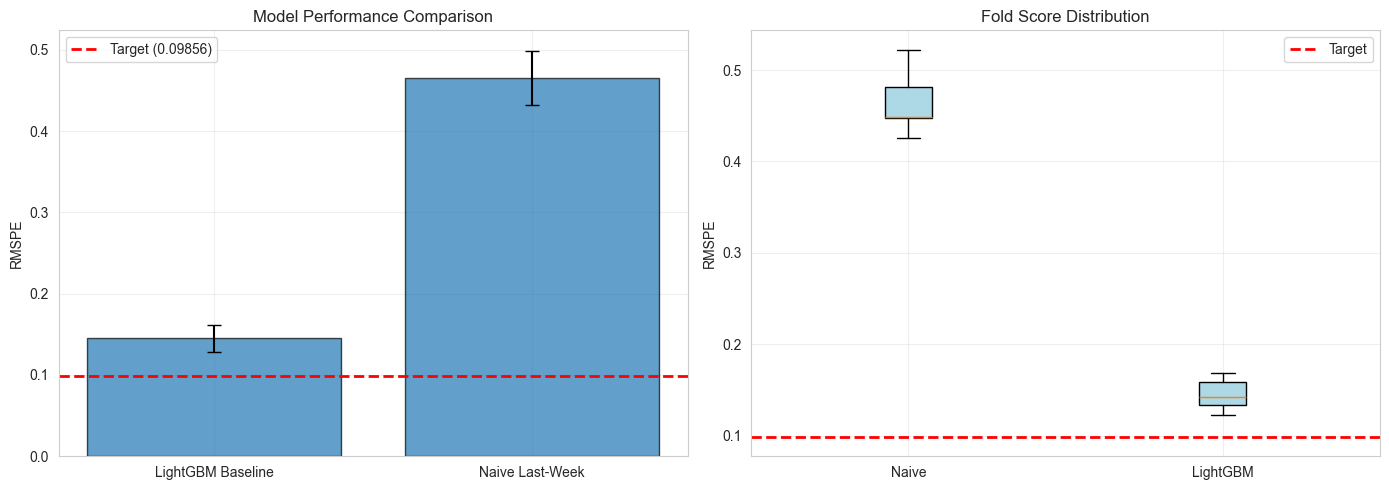

Saved: outputs/figures/11_baseline_comparison.png


In [14]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of mean RMSPE
ax = axes[0]
models = comparison_df['Model']
means = comparison_df['Mean RMSPE']
stds = comparison_df['Std RMSPE']

ax.bar(range(len(models)), means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=0)
ax.set_ylabel('RMSPE')
ax.set_title('Model Performance Comparison')
ax.axhline(y=0.09856, color='red', linestyle='--', label='Target (0.09856)', linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3)

# Box plot of fold scores
ax = axes[1]
fold_scores = [naive_results['fold_scores'], lgb_results['fold_scores']]
bp = ax.boxplot(fold_scores, tick_labels=['Naive', 'LightGBM'], patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.set_ylabel('RMSPE')
ax.set_title('Fold Score Distribution')
ax.axhline(y=0.09856, color='red', linestyle='--', label='Target', linewidth=2)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/11_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/figures/11_baseline_comparison.png")

## 8. Analysis of Results

In [15]:
print("="*60)
print("BASELINE MODEL ANALYSIS")
print("="*60)

# Calculate improvement
naive_mean = naive_results['mean_score']
lgb_mean = lgb_results['mean_score']
improvement = (naive_mean - lgb_mean) / naive_mean * 100

print(f"\nNaive Last-Week Model:")
print(f"  Mean RMSPE: {naive_mean:.6f}")
print(f"  This is our simplest baseline - just using last week's sales")

print(f"\nLightGBM Baseline:")
print(f"  Mean RMSPE: {lgb_mean:.6f}")
print(f"  Improvement over naive: {improvement:.2f}%")

print(f"\nTarget Performance:")
print(f"  Target RMSPE: 0.09856 (top 50 leaderboard)")
print(f"  Gap to target: {(lgb_mean - 0.09856):.6f}")
print(f"  Additional improvement needed: {((lgb_mean - 0.09856) / lgb_mean * 100):.2f}%")

print("\nNext Steps:")
print("  Phase 4 will focus on:")
print("  - Hyperparameter tuning")
print("  - Advanced models (XGBoost, CatBoost)")
print("  - Ensemble methods")
print("  - Additional feature engineering if needed")

print("="*60)

BASELINE MODEL ANALYSIS

Naive Last-Week Model:
  Mean RMSPE: 0.465426
  This is our simplest baseline - just using last week's sales

LightGBM Baseline:
  Mean RMSPE: 0.145059
  Improvement over naive: 68.83%

Target Performance:
  Target RMSPE: 0.09856 (top 50 leaderboard)
  Gap to target: 0.046499
  Additional improvement needed: 32.06%

Next Steps:
  Phase 4 will focus on:
  - Hyperparameter tuning
  - Advanced models (XGBoost, CatBoost)
  - Ensemble methods
  - Additional feature engineering if needed


## 9. Summary

In [16]:
print("\n" + "="*60)
print("Phase 3 Complete!")
print("="*60)
print(f"Implemented time-series CV with {len(folds)} expanding window folds")
print(f"Trained and evaluated 2 baseline models")
print(f"\nBest baseline: LightGBM with RMSPE = {lgb_mean:.6f}")
print(f"Baseline metrics saved to: outputs/metrics/baseline/")
print(f"\nReady for Phase 4: Advanced Models & Ensembles")
print("="*60)


Phase 3 Complete!
Implemented time-series CV with 5 expanding window folds
Trained and evaluated 2 baseline models

Best baseline: LightGBM with RMSPE = 0.145059
Baseline metrics saved to: outputs/metrics/baseline/

Ready for Phase 4: Advanced Models & Ensembles
